## Create an ActiveLearner

Now that we have an initial dataset, we can load it into an `ActiveLearner` object with a model.

Any fastai and timm models are supported. For simplicity, we will use a `resnet18` model.

In [1]:
from active_vision import ActiveLearner

al = ActiveLearner(name="cycle-4")
al.load_model(model="resnet18", pretrained=True, device="mps")

2025-02-01 23:30:05.113 | INFO     | active_vision.core:load_model:70 - Loading a pretrained timm model `resnet18` on `mps`


We can load the initial samples into the `ActiveLearner` object.

In [2]:
import pandas as pd

active_labeled_df = pd.read_parquet("active_labeled.parquet")

active_labeled_df

,filepath,label
0,data/imagenette/train/n02102040/n02102040_2788...,English springer
1,data/imagenette/train/n02102040/n02102040_3759...,English springer
2,data/imagenette/train/n02102040/n02102040_1916...,English springer
3,data/imagenette/train/n02102040/n02102040_6147...,English springer
4,data/imagenette/train/n02102040/n02102040_403....,English springer
...,...,...
238,data/imagenette/train/n03417042/n03417042_1869...,garbage truck
239,data/imagenette/train/n02102040/n02102040_6763...,English springer
240,data/imagenette/train/n01440764/n01440764_1455...,tench
241,data/imagenette/train/n03028079/n03028079_2489...,church


In [3]:
al.load_dataset(
    active_labeled_df,
    filepath_col="filepath",
    label_col="label",
    batch_size=8,
    image_size=224,
)

2025-02-01 23:30:06.219 | INFO     | active_vision.core:load_dataset:119 - Loading dataset from `filepath` and `label` columns
2025-02-01 23:30:06.300 | INFO     | active_vision.core:load_dataset:153 - Creating new learner
2025-02-01 23:30:06.773 | INFO     | active_vision.core:_optimize_learner:97 - Enabled mixed precision training
2025-02-01 23:30:06.774 | INFO     | active_vision.core:_finalize_setup:105 - Done. Ready to train.


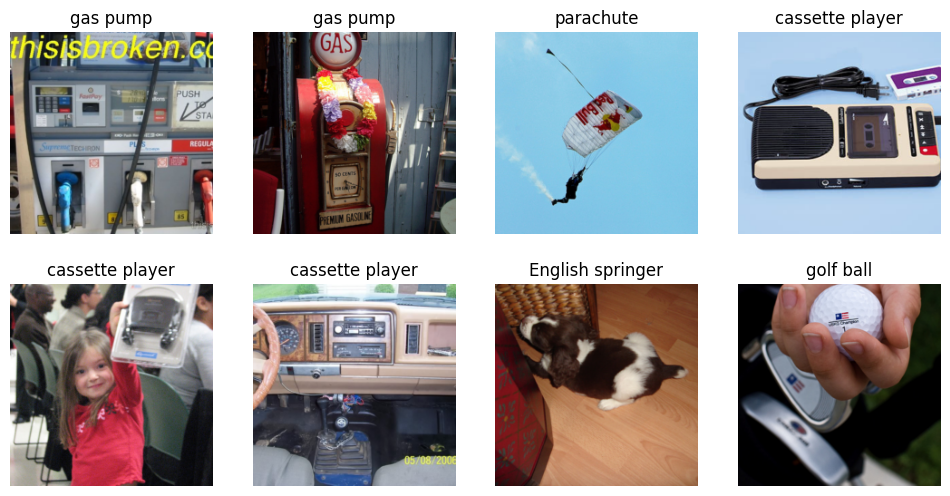

In [4]:
al.show_batch()

You can inspect the train and validation sets too.

In [5]:
len(al.train_set)

195

In [6]:
len(al.valid_set)

48

## Train 

Now that we have the initial dataset, we can train the model.

But first, let's check the optimal learning rate for the model.

2025-02-01 23:30:10.436 | INFO     | active_vision.core:lr_find:194 - Finding optimal learning rate
/Users/dnth/Desktop/active-vision/.venv/lib/python3.12/site-packages/torch/amp/autocast_mode.py:266: UserWarning: User provided device_type of 'cuda', but CUDA is not available. Disabling
  warnings.warn(
/Users/dnth/Desktop/active-vision/.venv/lib/python3.12/site-packages/torch/amp/grad_scaler.py:132: UserWarning: torch.cuda.amp.GradScaler is enabled, but CUDA is not available.  Disabling.
  warnings.warn(


2025-02-01 23:30:15.370 | INFO     | active_vision.core:lr_find:196 - Optimal learning rate: 0.0030199517495930195


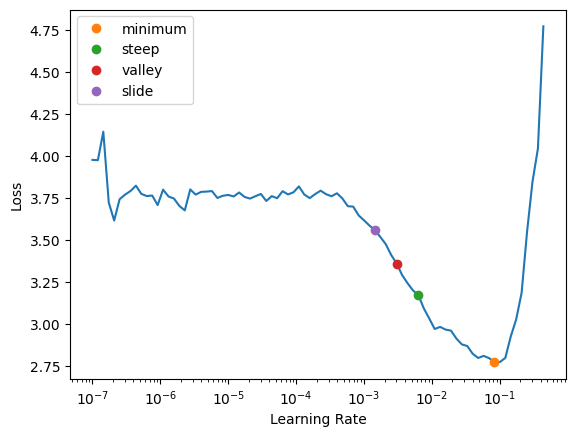

In [7]:
al.lr_find()

Not let's use the optimal learning rate to train the model end-to-end for 3 epochs and 1 epoch of head tuning.

2025-02-01 23:30:15.606 | INFO     | active_vision.core:train:207 - Training head for 3 epochs
2025-02-01 23:30:15.606 | INFO     | active_vision.core:train:208 - Training model end-to-end for 10 epochs
2025-02-01 23:30:15.607 | INFO     | active_vision.core:train:209 - Learning rate: 0.005 with one-cycle learning rate scheduler


epoch,train_loss,valid_loss,accuracy,time
0,3.422156,1.291675,0.562500,00:01
1,2.149174,0.769172,0.729167,00:01
2,1.528523,0.780796,0.750000,00:01


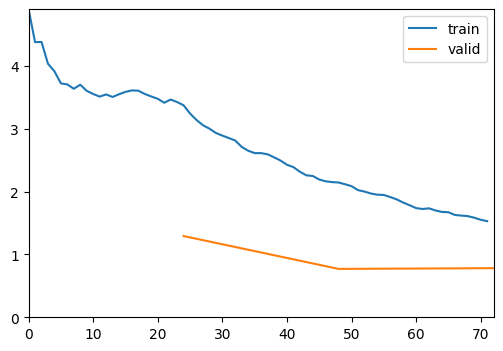

epoch,train_loss,valid_loss,accuracy,time
0,0.746164,0.762358,0.729167,00:02
1,0.687012,0.769352,0.750000,00:01
2,0.762452,0.821088,0.687500,00:01
3,0.679784,0.890716,0.687500,00:01
4,0.660756,1.014748,0.666667,00:01
5,0.530249,0.848102,0.750000,00:01
6,0.514435,0.876903,0.708333,00:01
7,0.459882,0.899567,0.645833,00:01
8,0.439547,0.845213,0.687500,00:01
9,0.463875,0.874893,0.687500,00:01


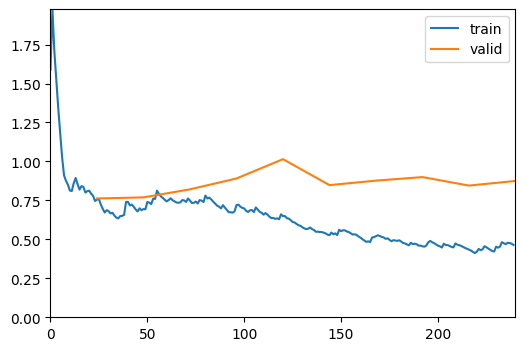

In [8]:
al.train(epochs=10, lr=5e-3, head_tuning_epochs=3)

## Evaluate

Now that we have a trained model, we can evaluate it on the evaluation set.

In [9]:
evaluation_df = pd.read_parquet("evaluation_samples.parquet")
evaluation_df

,filepath,label
0,data/imagenette/val/n03394916/n03394916_32422....,French horn
1,data/imagenette/val/n03394916/n03394916_69132....,French horn
2,data/imagenette/val/n03394916/n03394916_33771....,French horn
3,data/imagenette/val/n03394916/n03394916_29940....,French horn
4,data/imagenette/val/n03394916/ILSVRC2012_val_0...,French horn
...,...,...
3920,data/imagenette/val/n02979186/n02979186_27392....,cassette player
3921,data/imagenette/val/n02979186/n02979186_2742.JPEG,cassette player
3922,data/imagenette/val/n02979186/n02979186_2312.JPEG,cassette player
3923,data/imagenette/val/n02979186/n02979186_12822....,cassette player


In [10]:
al.evaluate(evaluation_df, filepath_col="filepath", label_col="label")

/Users/dnth/Desktop/active-vision/.venv/lib/python3.12/site-packages/torch/amp/autocast_mode.py:266: UserWarning: User provided device_type of 'cuda', but CUDA is not available. Disabling
  warnings.warn(
/Users/dnth/Desktop/active-vision/.venv/lib/python3.12/site-packages/torch/amp/grad_scaler.py:132: UserWarning: torch.cuda.amp.GradScaler is enabled, but CUDA is not available.  Disabling.
  warnings.warn(


2025-02-01 23:30:55.320 | INFO     | active_vision.core:evaluate:285 - Accuracy: 94.52%


0.9452229299363057

In [11]:
al.summary()

2025-02-01 23:30:55.326 | INFO     | active_vision.core:summary:578 - Saved results to cycle-4_20250201_233055_acc_94.52%_n_243.parquet


,name,accuracy,train_set_size,valid_set_size,dataset_size,num_classes,model,pretrained,loss_fn,device,seed,batch_size,image_size
0,cycle-4,0.945223,195,48,243,10,resnet18,True,FlattenedLoss of CrossEntropyLoss(),mps,None,8,224


## Predict

Using the model, we can predict the labels of the unlabeled samples and get the most impactful samples to label.


In [12]:
df = pd.read_parquet("unlabeled_samples.parquet")
filepaths = df["filepath"].tolist()
len(filepaths)

9369

In [13]:
pred_df = al.predict(filepaths, batch_size=128)
pred_df

2025-02-01 23:31:03.888 | INFO     | active_vision.core:predict:216 - Running inference on 9369 samples
/Users/dnth/Desktop/active-vision/.venv/lib/python3.12/site-packages/torch/amp/autocast_mode.py:266: UserWarning: User provided device_type of 'cuda', but CUDA is not available. Disabling
  warnings.warn(
/Users/dnth/Desktop/active-vision/.venv/lib/python3.12/site-packages/torch/amp/grad_scaler.py:132: UserWarning: torch.cuda.amp.GradScaler is enabled, but CUDA is not available.  Disabling.
  warnings.warn(


,filepath,pred_label,pred_conf,probs,logits,embeddings
0,data/imagenette/train/n03394916/n03394916_4437...,French horn,0.9984,"[0.0, 0.9984, 0.0002, 0.0, 0.0006, 0.0, 0.0004...","[-1.9589, 8.2279, -0.1242, -2.4688, 0.8373, -4...","[-1.2464, -0.5723, 1.7163, 2.3322, -1.9943, 2...."
1,data/imagenette/train/n03394916/n03394916_4241...,French horn,1.0000,"[0.0, 1.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, ...","[0.0226, 13.4169, -1.9615, -5.7146, 3.0123, -0...","[3.525, 0.2096, 8.0362, 3.0925, 1.3328, -0.709..."
2,data/imagenette/train/n03394916/n03394916_3880...,French horn,0.9918,"[0.0001, 0.9918, 0.0, 0.0002, 0.0028, 0.0, 0.0...","[-1.6084, 7.8224, -2.1063, -0.5879, 1.9445, -3...","[5.229, 1.8498, -0.202, 3.286, 0.6647, -1.1609..."
3,data/imagenette/train/n03394916/n03394916_2412...,French horn,0.9969,"[0.0001, 0.9969, 0.0001, 0.0, 0.0002, 0.0, 0.0...","[0.2467, 9.6554, 0.6257, -0.2665, 0.9963, -3.6...","[1.0003, 2.8636, 2.7848, 3.1567, 0.9976, 4.265..."
4,data/imagenette/train/n03394916/n03394916_1128...,French horn,0.9902,"[0.0009, 0.9902, 0.0, 0.0011, 0.0059, 0.0017, ...","[0.9064, 7.9291, -4.0923, 1.1315, 2.7998, 1.57...","[5.9739, 2.2213, 1.2884, 0.3415, 5.2111, -1.08..."
...,...,...,...,...,...,...
9364,data/imagenette/train/n02979186/n02979186_8089...,cassette player,0.9987,"[0.0001, 0.0001, 0.9987, 0.0006, 0.0001, 0.0, ...","[0.0422, 0.7472, 9.8391, 2.4154, 0.3385, -3.00...","[-7.9552, 1.6392, -3.4431, 1.0127, -1.2747, 3...."
9365,data/imagenette/train/n02979186/n02979186_1944...,cassette player,0.9935,"[0.0002, 0.0018, 0.9935, 0.0026, 0.0004, 0.0, ...","[-0.5203, 1.6686, 7.9666, 2.0088, 0.2276, -3.5...","[-3.6869, 3.918, 0.4079, -0.4204, -2.5597, 3.2..."
9366,data/imagenette/train/n02979186/n02979186_1107...,cassette player,0.9652,"[0.0, 0.0001, 0.9652, 0.0317, 0.0003, 0.0001, ...","[-3.0793, -2.0475, 7.0196, 3.6029, -0.9687, -2...","[-0.6445, 0.2469, -3.7268, 1.5166, -2.0066, -2..."
9367,data/imagenette/train/n02979186/n02979186_2938...,cassette player,0.9404,"[0.0003, 0.0508, 0.9404, 0.0057, 0.0015, 0.000...","[-2.0067, 3.239, 6.1576, 1.0453, -0.305, -2.01...","[-0.3624, 1.2276, -1.0508, 2.6694, -4.1254, -3..."


## Sample

With the predicted labels, we can sample the most impactful samples to label using active learning strategies.

For this example, we will use the `sample_uncertain` strategy to sample the most uncertain samples. This will pull out samples that the model is most unsure about.


In [ ]:
samples = al.sample_combination(
    pred_df,
    num_samples=50,
    combination={
        "least-confidence": 0.4,
        "ratio-of-confidence": 0.2,
        "entropy": 0.2,
        "model-based-outlier": 0.1,
        "random": 0.1,
    },
)

samples

## Label

Let's label the 10 most uncertain samples.

In [ ]:
al.label(samples, output_filename="combination.parquet")

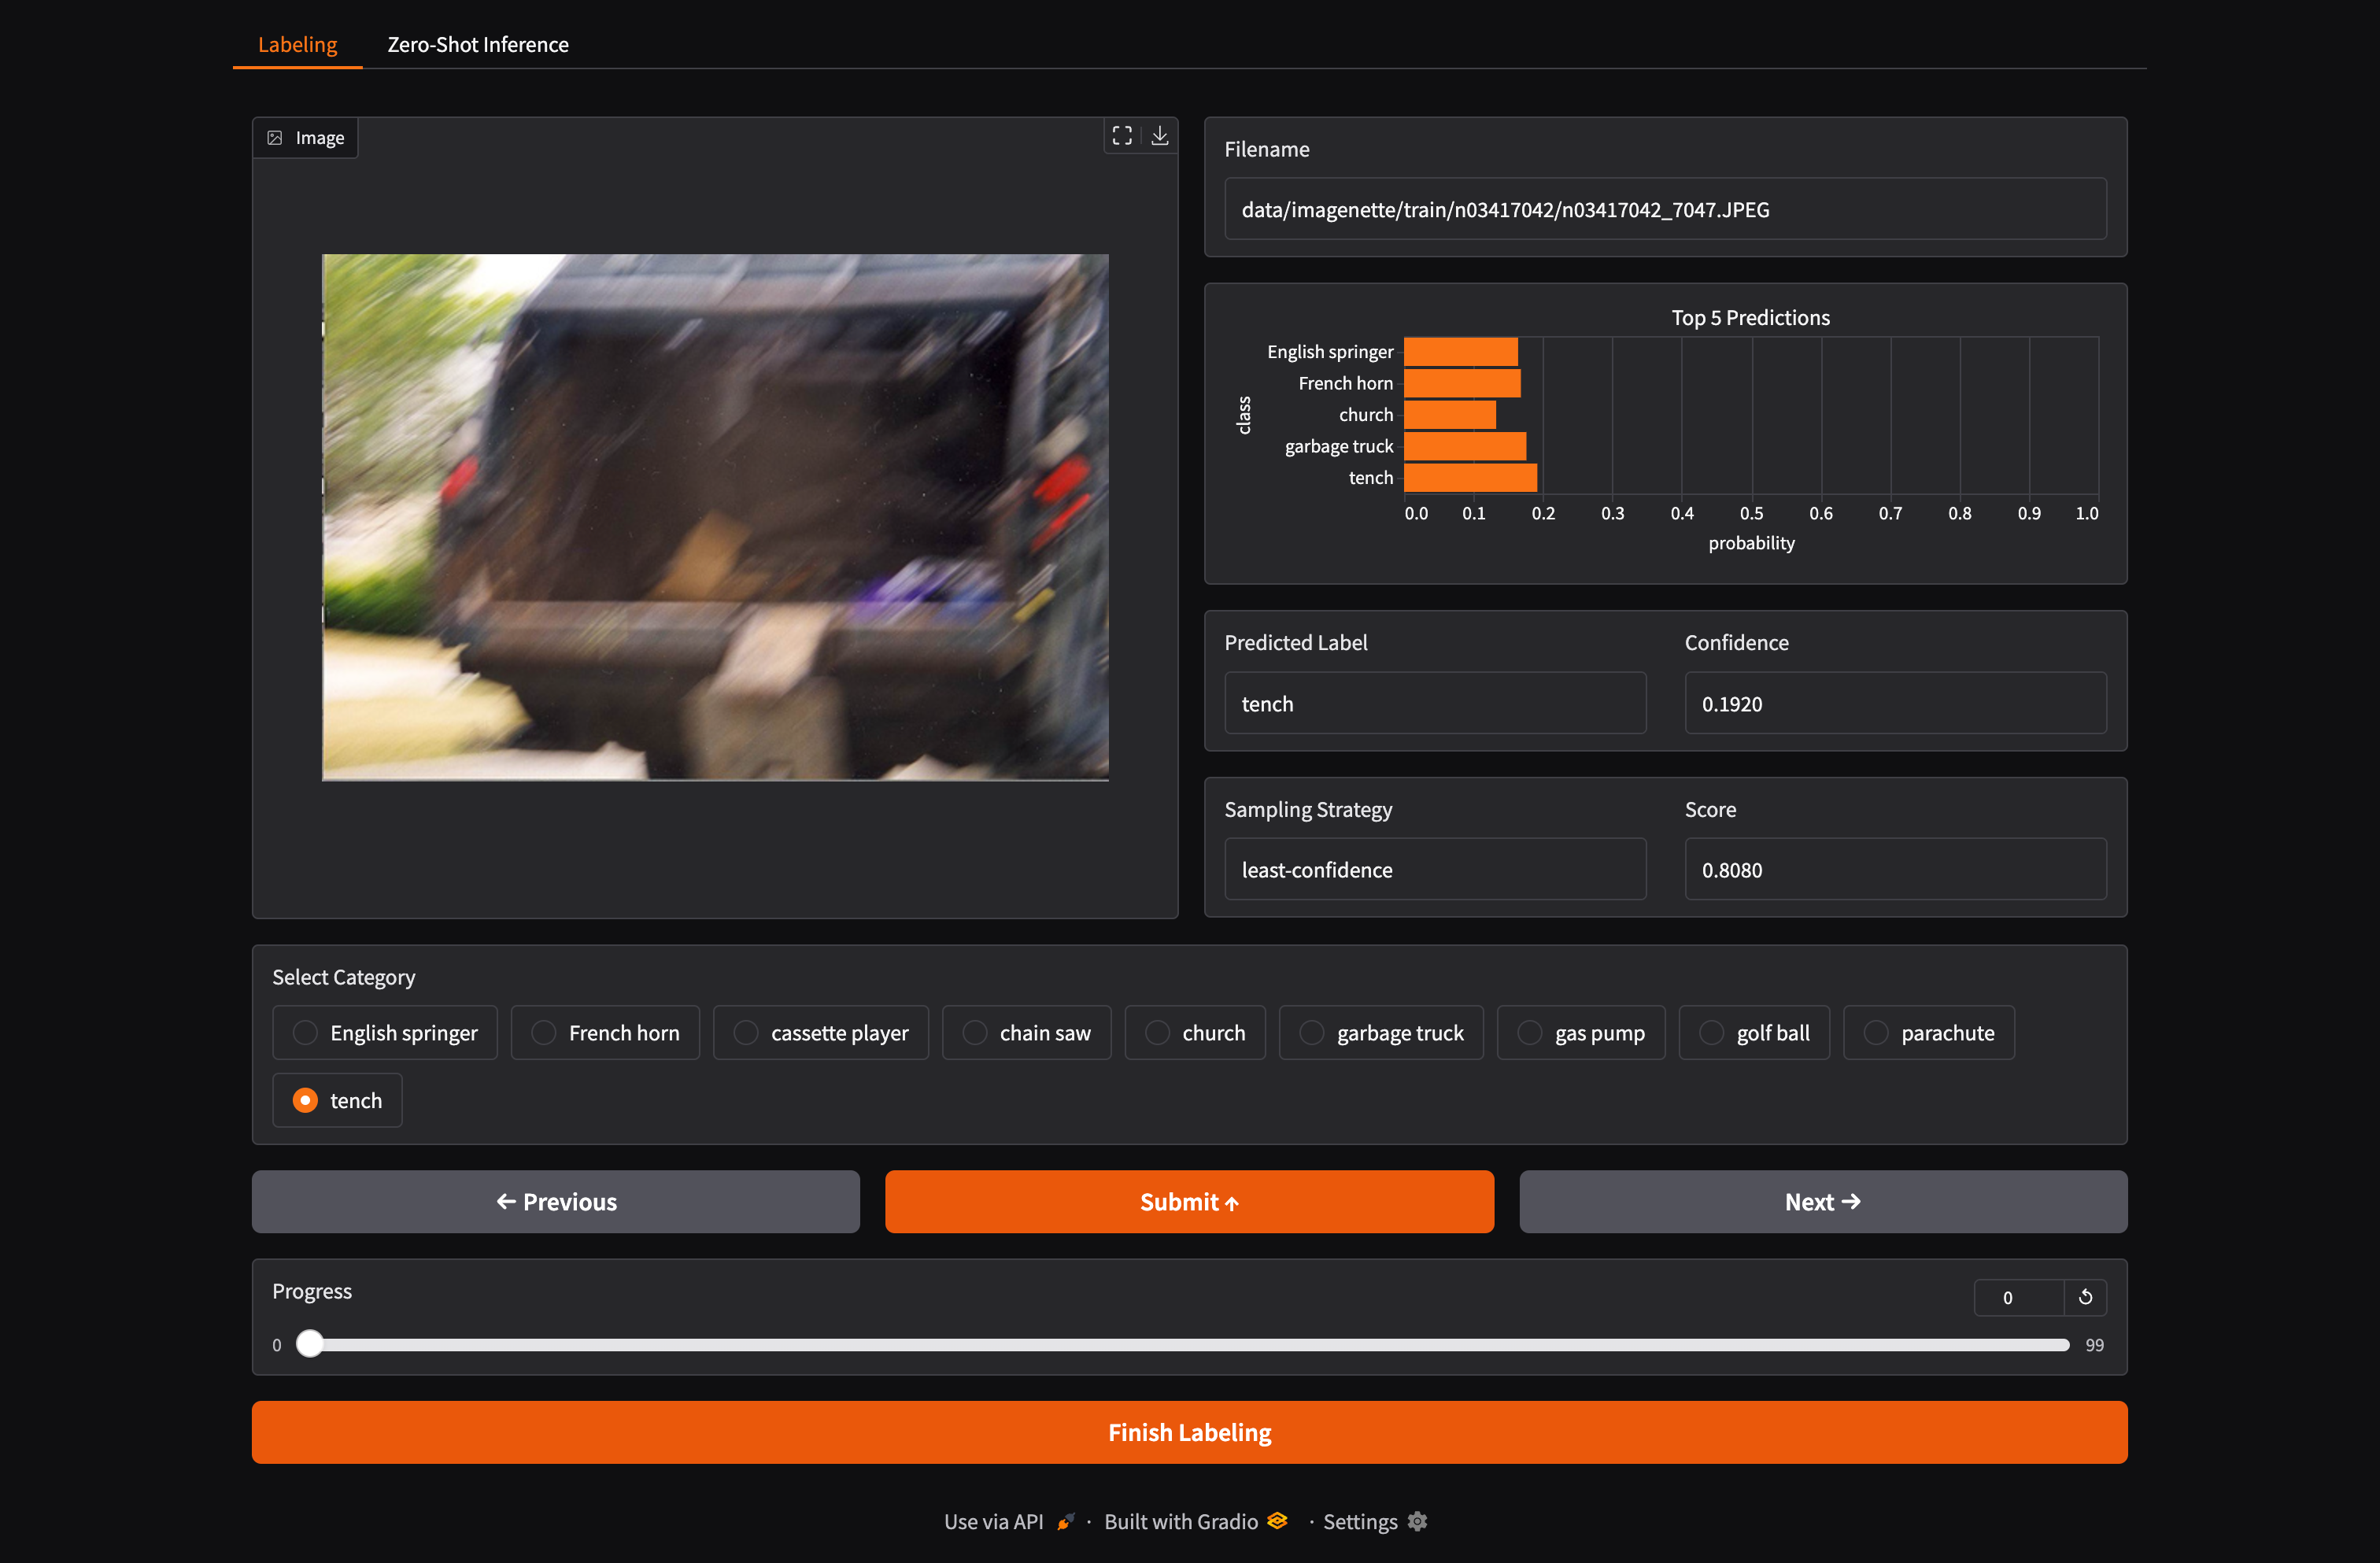

The Gradio interface will open up and you can label the samples. You could also see the confidence of the model for each sample to debug the model.

In [ ]:
labeled_df = pd.read_parquet("combination.parquet")

labeled_df


## Add to train set

Now that we have labeled the samples, we can add them to the train set.

In [ ]:
al.add_to_dataset(labeled_df, output_filename="active_labeled.parquet")

In [ ]:
# Read all parquet files in the directory that has name "cycle" and concatenate them

import glob
import pandas as pd

# Get all parquet files with 'cycle' in the name
cycle_files = glob.glob("cycle-*.parquet")

# Read and concatenate all cycle files
all_cycles_df = pd.concat([pd.read_parquet(f) for f in cycle_files], ignore_index=True)

all_cycles_df = all_cycles_df.sort_values(by="name", ascending=True)
all_cycles_df


## Repeat

We can repeat the process of predicting, sampling, labeling, and adding to the train set until we have a good model.